Initial Imports

In [163]:
import csv
import time
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
from datetime import datetime, timedelta
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Generate map of cities and their respective coordinates

In [164]:
# Replace 'file.csv' with your CSV file's name and path
file_path = 'data/tr.csv'

# Create an empty dictionary to store city coordinates
city_coordinates = {}

# Open the CSV file and read data
with open(file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        city = row['city']
        lat = float(row['lat'])
        lng = float(row['lng'])
        city_coordinates[city] = (lat, lng)

# Display the dictionary containing city coordinates
for city, coordinates in city_coordinates.items():
    print(f"City: {city}, Coordinates: {coordinates}")
city_coordinates

City: Istanbul, Coordinates: (41.0136, 28.955)
City: Ankara, Coordinates: (39.93, 32.85)
City: İzmir, Coordinates: (38.42, 27.14)
City: Bursa, Coordinates: (40.1833, 29.05)
City: Antalya, Coordinates: (36.8874, 30.7075)
City: Konya, Coordinates: (37.8667, 32.4833)
City: Gaziantep, Coordinates: (37.0628, 37.3792)
City: Şanlıurfa, Coordinates: (37.1583, 38.7917)
City: Mersin, Coordinates: (36.8, 34.6333)
City: Adana, Coordinates: (37.0, 35.3213)
City: Diyarbakır, Coordinates: (37.91, 40.24)
City: Kayseri, Coordinates: (38.7225, 35.4875)
City: Samsun, Coordinates: (41.2903, 36.3336)
City: Akçaabat, Coordinates: (41.0167, 39.55)
City: Denizli, Coordinates: (37.7667, 29.0833)
City: Çankaya, Coordinates: (39.9244, 32.8856)
City: Esenyurt, Coordinates: (41.047, 28.658)
City: Eskişehir, Coordinates: (39.7767, 30.5206)
City: Seyhan, Coordinates: (36.9831, 35.3328)
City: Küçükçekmece, Coordinates: (41.0, 28.8)
City: Erzurum, Coordinates: (39.9086, 41.2769)
City: Bağcılar, Coordinates: (41.0344, 

{'Istanbul': (41.0136, 28.955),
 'Ankara': (39.93, 32.85),
 'İzmir': (38.42, 27.14),
 'Bursa': (40.1833, 29.05),
 'Antalya': (36.8874, 30.7075),
 'Konya': (37.8667, 32.4833),
 'Gaziantep': (37.0628, 37.3792),
 'Şanlıurfa': (37.1583, 38.7917),
 'Mersin': (36.8, 34.6333),
 'Adana': (37.0, 35.3213),
 'Diyarbakır': (37.91, 40.24),
 'Kayseri': (38.7225, 35.4875),
 'Samsun': (41.2903, 36.3336),
 'Akçaabat': (41.0167, 39.55),
 'Denizli': (37.7667, 29.0833),
 'Çankaya': (39.9244, 32.8856),
 'Esenyurt': (41.047, 28.658),
 'Eskişehir': (39.7767, 30.5206),
 'Seyhan': (36.9831, 35.3328),
 'Küçükçekmece': (41.0, 28.8),
 'Erzurum': (39.9086, 41.2769),
 'Bağcılar': (41.0344, 28.8564),
 'Pendik': (40.8747, 29.235),
 'Selçuklu': (37.8814, 32.4922),
 'Yıldırım': (40.11, 29.0821),
 'Kartal': (40.8872, 29.19),
 'Batman': (37.887, 41.132),
 'Esenler': (41.0339, 28.8903),
 'Kahramanmaraş': (37.5833, 36.9333),
 'Kâğıthane': (41.0719, 28.9664),
 'Avcılar': (40.9792, 28.7214),
 'Trabzon': (41.005, 39.7225),
 '

In [165]:
today = datetime.now() - timedelta(days=1) # Get today's date
one_year_ago = today - timedelta(days=365)  # Subtract 365 days for one year
today

datetime.datetime(2024, 1, 7, 17, 35, 58, 268593)

In [166]:
def format_date(date):
	formatted_date = date.strftime('%Y-%m-%d')
	return formatted_date

In [167]:
def api_call(lat,long):
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)
	
	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date": format_date(one_year_ago),
		"end_date": format_date(today),
		"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m"]
	}
	responses = openmeteo.weather_api(url, params=params)
	
	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
	print(f"Elevation {response.Elevation()} m asl")
	
	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_rain = hourly.Variables(2).ValuesAsNumpy()
	hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
	hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
	
	hourly_data = {"date": pd.date_range(
		start=pd.to_datetime(hourly.Time(), unit="s"),
		end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
		freq=pd.Timedelta(seconds=hourly.Interval()),
		inclusive="left"
	), "temperature_2m": hourly_temperature_2m, "relative_humidity_2m": hourly_relative_humidity_2m, "rain": hourly_rain,
		"snowfall": hourly_snowfall, "surface_pressure": hourly_surface_pressure, "cloud_cover": hourly_cloud_cover,
		"wind_speed_10m": hourly_wind_speed_10m}
	
	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe

In [168]:
data_frame = pd.DataFrame
for city, (lat, lng) in city_coordinates.items():
    df = api_call(lat, lng)
    df['city_name'] = city
    df['latitude'] = lat
    df['longitude'] = lng
    if data_frame.empty:
        data_frame = df
    else:
        data_frame = pd.concat((data_frame, df))
data_frame

Coordinates 41.01932907104492°E 29.01569175720215°N
Elevation 41.0 m asl
Coordinates 39.964847564697266°E 32.68156433105469°N
Elevation 848.0 m asl
Coordinates 38.418277740478516°E 27.19512176513672°N
Elevation 13.0 m asl
Coordinates 40.17574691772461°E 28.90603256225586°N
Elevation 257.0 m asl
Coordinates 36.8717041015625°E 30.789474487304688°N
Elevation 46.0 m asl
Coordinates 37.85588455200195°E 32.573726654052734°N
Elevation 1025.0 m asl
Coordinates 37.08259963989258°E 37.450462341308594°N
Elevation 842.0 m asl
Coordinates 37.152896881103516°E 38.80952453613281°N
Elevation 525.0 m asl
Coordinates 36.8014030456543°E 34.53350830078125°N
Elevation 10.0 m asl
Coordinates 37.01230239868164°E 35.263851165771484°N
Elevation 28.0 m asl
Coordinates 37.926185607910156°E 40.228187561035156°N
Elevation 661.0 m asl
Coordinates 38.69947052001953°E 35.313350677490234°N
Elevation 1057.0 m asl
Coordinates 41.3005256652832°E 36.28407287597656°N
Elevation 13.0 m asl
Coordinates 41.01932907104492°E 39.

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,city_name,latitude,longitude
0,2023-01-07 00:00:00,6.7235,88.602036,0.0,0.0,1019.487610,23.099998,7.244860,Istanbul,41.0136,28.9550
1,2023-01-07 01:00:00,6.7735,85.868866,0.0,0.0,1019.787109,48.600002,4.896529,Istanbul,41.0136,28.9550
2,2023-01-07 02:00:00,4.0235,94.523346,0.0,0.0,1019.537109,46.799999,6.151683,Istanbul,41.0136,28.9550
3,2023-01-07 03:00:00,3.8735,96.201035,0.0,0.0,1019.634155,100.000000,5.052841,Istanbul,41.0136,28.9550
4,2023-01-07 04:00:00,4.4235,95.880096,0.0,0.0,1019.843384,38.099998,4.334974,Istanbul,41.0136,28.9550
...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-01-07 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,40.7797,29.3945
8780,2024-01-07 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,40.7797,29.3945
8781,2024-01-07 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,40.7797,29.3945
8782,2024-01-07 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Darıca,40.7797,29.3945


In [169]:
data_frame.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,city_name,latitude,longitude
0,2023-01-07 00:00:00,6.7235,88.602036,0.0,0.0,1019.487610,23.099998,7.244860,Istanbul,41.0136,28.955
1,2023-01-07 01:00:00,6.7735,85.868866,0.0,0.0,1019.787109,48.600002,4.896529,Istanbul,41.0136,28.955
2,2023-01-07 02:00:00,4.0235,94.523346,0.0,0.0,1019.537109,46.799999,6.151683,Istanbul,41.0136,28.955
3,2023-01-07 03:00:00,3.8735,96.201035,0.0,0.0,1019.634155,100.000000,5.052841,Istanbul,41.0136,28.955
4,2023-01-07 04:00:00,4.4235,95.880096,0.0,0.0,1019.843384,38.099998,4.334974,Istanbul,41.0136,28.955


# Feature selection

In [170]:
print(data_frame.columns)

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'rain', 'snowfall',
       'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'city_name',
       'latitude', 'longitude'],
      dtype='object')


In [171]:
data_frame['date'] = pd.to_datetime(data_frame['date']).astype('int64') / 10**9  # Convert nanoseconds to seconds
selected_features = data_frame[['date', 'latitude', 'longitude']]

target_variables = ['rain','snowfall', 'cloud_cover', 'wind_speed_10m','surface_pressure']

# Assuming you want to predict each target variable for the next hour
for target_variable in target_variables:
    # Shift the target variable by 1 hour to align with features
    data_frame[target_variable] = data_frame[target_variable].shift(-1)

# Drop the last row to maintain alignment of features and labels
data_frame = data_frame.dropna()
data_frame

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,city_name,latitude,longitude
0,1.673050e+09,6.723500,88.602036,0.0,0.0,1019.787109,48.600002,4.896529,Istanbul,41.0136,28.9550
1,1.673053e+09,6.773500,85.868866,0.0,0.0,1019.537109,46.799999,6.151683,Istanbul,41.0136,28.9550
2,1.673057e+09,4.023500,94.523346,0.0,0.0,1019.634155,100.000000,5.052841,Istanbul,41.0136,28.9550
3,1.673060e+09,3.873500,96.201035,0.0,0.0,1019.843384,38.099998,4.334974,Istanbul,41.0136,28.9550
4,1.673064e+09,4.423500,95.880096,0.0,0.0,1020.244934,27.000002,3.319036,Istanbul,41.0136,28.9550
...,...,...,...,...,...,...,...,...,...,...,...
8730,1.704478e+09,9.493999,81.832985,0.0,0.0,1013.372742,0.300000,7.928178,Darıca,40.7797,29.3945
8731,1.704481e+09,8.444000,85.157410,0.0,0.0,1013.472046,17.100000,10.105681,Darıca,40.7797,29.3945
8732,1.704485e+09,8.444000,81.978683,0.0,0.0,1013.181458,12.600000,12.015589,Darıca,40.7797,29.3945
8733,1.704488e+09,8.743999,76.516251,0.0,0.0,1012.984131,21.300001,12.144331,Darıca,40.7797,29.3945


In [172]:
# Splitting features and labels
X = data_frame[selected_features.columns]  # Features
X

,date,latitude,longitude
0,1.673050e+09,41.0136,28.9550
1,1.673053e+09,41.0136,28.9550
2,1.673057e+09,41.0136,28.9550
3,1.673060e+09,41.0136,28.9550
4,1.673064e+09,41.0136,28.9550
...,...,...,...
8730,1.704478e+09,40.7797,29.3945
8731,1.704481e+09,40.7797,29.3945
8732,1.704485e+09,40.7797,29.3945
8733,1.704488e+09,40.7797,29.3945


In [173]:
y = data_frame[target_variables]  # Labels
y

,rain,snowfall,cloud_cover,wind_speed_10m,surface_pressure
0,0.0,0.0,48.600002,4.896529,1019.787109
1,0.0,0.0,46.799999,6.151683,1019.537109
2,0.0,0.0,100.000000,5.052841,1019.634155
3,0.0,0.0,38.099998,4.334974,1019.843384
4,0.0,0.0,27.000002,3.319036,1020.244934
...,...,...,...,...,...
8730,0.0,0.0,0.300000,7.928178,1013.372742
8731,0.0,0.0,17.100000,10.105681,1013.472046
8732,0.0,0.0,12.600000,12.015589,1013.181458
8733,0.0,0.0,21.300001,12.144331,1012.984131


# Creating Test and Training Data

In [174]:
# Select numerical columns only for conversion to tensors
numerical_columns_X = X.select_dtypes(include=['float32', 'float64']).columns
X_numeric = X[numerical_columns_X]
X_numeric

,date,latitude,longitude
0,1.673050e+09,41.0136,28.9550
1,1.673053e+09,41.0136,28.9550
2,1.673057e+09,41.0136,28.9550
3,1.673060e+09,41.0136,28.9550
4,1.673064e+09,41.0136,28.9550
...,...,...,...
8730,1.704478e+09,40.7797,29.3945
8731,1.704481e+09,40.7797,29.3945
8732,1.704485e+09,40.7797,29.3945
8733,1.704488e+09,40.7797,29.3945


In [175]:
# Initialize StandardScaler
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)
X_numeric = pd.DataFrame(X_numeric, columns=numerical_columns_X)
X_numeric

,date,latitude,longitude
0,-1.731853,1.135103,-0.908645
1,-1.731456,1.135103,-0.908645
2,-1.731059,1.135103,-0.908645
3,-1.730663,1.135103,-0.908645
4,-1.730266,1.135103,-0.908645
...,...,...,...
1773200,1.730266,0.989050,-0.821678
1773201,1.730663,0.989050,-0.821678
1773202,1.731059,0.989050,-0.821678
1773203,1.731456,0.989050,-0.821678


In [176]:
numerical_columns_y = y.select_dtypes(include=['float32', 'float64']).columns
y_numeric = y[numerical_columns_y]
y_numeric

,rain,snowfall,cloud_cover,wind_speed_10m,surface_pressure
0,0.0,0.0,48.600002,4.896529,1019.787109
1,0.0,0.0,46.799999,6.151683,1019.537109
2,0.0,0.0,100.000000,5.052841,1019.634155
3,0.0,0.0,38.099998,4.334974,1019.843384
4,0.0,0.0,27.000002,3.319036,1020.244934
...,...,...,...,...,...
8730,0.0,0.0,0.300000,7.928178,1013.372742
8731,0.0,0.0,17.100000,10.105681,1013.472046
8732,0.0,0.0,12.600000,12.015589,1013.181458
8733,0.0,0.0,21.300001,12.144331,1012.984131


In [177]:
# Convert numerical columns to PyTorch tensors
X_tensor = torch.tensor(X_numeric.values, dtype=torch.float32)
X_tensor

tensor([[-1.7319,  1.1351, -0.9086],
        [-1.7315,  1.1351, -0.9086],
        [-1.7311,  1.1351, -0.9086],
        ...,
        [ 1.7311,  0.9891, -0.8217],
        [ 1.7315,  0.9891, -0.8217],
        [ 1.7319,  0.9891, -0.8217]])

In [178]:
y_tensor = torch.tensor(y_numeric.values, dtype=torch.float32)
y_tensor

tensor([[   0.0000,    0.0000,   48.6000,    4.8965, 1019.7871],
        [   0.0000,    0.0000,   46.8000,    6.1517, 1019.5371],
        [   0.0000,    0.0000,  100.0000,    5.0528, 1019.6342],
        ...,
        [   0.0000,    0.0000,   12.6000,   12.0156, 1013.1815],
        [   0.0000,    0.0000,   21.3000,   12.1443, 1012.9841],
        [   0.0000,    0.0000,   15.3000,   12.2241, 1012.4803]])

In [179]:
# Check for missing values in X_tensor and y_tensor
missing_X = np.isnan(X_tensor).any()
missing_y = np.isnan(y_tensor).any()
print(f"Missing values in X_tensor: {missing_X}")
print(f"Missing values in y_tensor: {missing_y}")

# Verify the lengths of X_tensor and y_tensor
print(f"Length of X_tensor: {len(X_tensor)}")
print(f"Length of y_tensor: {len(y_tensor)}")

Missing values in X_tensor: 0
Missing values in y_tensor: 0
Length of X_tensor: 1773205
Length of y_tensor: 1773205


In [180]:
# Split data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test

(tensor([[ 0.7991, -0.0313,  0.1215],
         [ 1.5677, -0.5281, -0.9954],
         [-0.4362,  0.7892,  1.1736],
         ...,
         [-1.3722,  0.4550, -0.1309],
         [ 1.1612,  0.9610, -0.3838],
         [ 1.6006,  1.1370,  1.1879]]),
 tensor([[-1.4761,  1.3799, -1.2249],
         [-0.1685,  1.1273, -0.9706],
         [-0.3553, -1.8691,  0.5172],
         ...,
         [ 1.6640,  1.0378, -0.8760],
         [-0.6175,  0.4527,  2.0772],
         [-1.6680, -0.0558,  1.1873]]),
 tensor([[  0.0000,   0.0000,   0.0000,   4.1046, 903.5237],
         [  0.0000,   0.0000,   0.0000,   2.4150, 997.6218],
         [  0.0000,   0.0000,  41.1000,   7.1458, 883.6562],
         ...,
         [  0.0000,   0.0000,   0.0000,   5.0528, 912.4454],
         [  0.0000,   0.0000,  22.8000,   5.8048, 935.2233],
         [  0.0000,   0.0000,  91.2000,  13.2174, 961.3762]]),
 tensor([[   0.0000,    0.0000,    0.0000,    8.4734, 1010.0106],
         [   0.0000,    0.0000,    7.5000,    4.5108,  996.9824]

In [181]:
# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
train_dataset

In [182]:
test_dataset = TensorDataset(X_test, y_test)
test_dataset

In [183]:
# Define batch size for DataLoader
batch_size = 64
batch_size

64

In [184]:
# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader

In [185]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader

In [186]:
class BESTModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(BESTModel, self).__init__()
        layers = []
        prev_size = input_size
        self.hidden_sizes = hidden_sizes
        
        for idx, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch Normalization
            layers.append(nn.ReLU())  # ReLU activation
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer adjusted to match the number of labels (5 in this case)
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.network = nn.Sequential(*layers)
        
        # Weight initialization (optional)
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.BatchNorm1d)):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Implementing skip connections (residual connections)
        out = x
        for idx, layer in enumerate(self.network):
            out = layer(out)
            if idx % 4 == 3:  # After every 4 layers (Linear -> BatchNorm -> ReLU -> Dropout)
                if out.shape[1] == x.shape[1]:  # Check if the shapes match for addition
                    out += x  # Add the input (skip connection)
                x = out  # Update x for the next skip connection
        
        # Adjusting the output for the first 3 predictions to be within 0 and 1
        out[:, :3] = torch.sigmoid(out[:, :3])
        
        return out


In [187]:
# Define input, hidden, and output sizes based on your data
input_size = X_train.shape[1]  # Number of features
hidden_sizes = [64, 32]
output_size = y_train.shape[1]  # Number of output variables

In [188]:
# Initialize the more complex model
model = BESTModel(input_size, hidden_sizes, output_size)
model

BESTModel(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [189]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adam optimizer

In [190]:
# Train the model
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 19972.5426
Epoch [2/10], Loss: 2280.7877
Epoch [3/10], Loss: 2096.5776
Epoch [4/10], Loss: 2034.0643
Epoch [5/10], Loss: 1984.3152
Epoch [6/10], Loss: 1949.1215
Epoch [7/10], Loss: 1913.8767
Epoch [8/10], Loss: 1876.2754
Epoch [9/10], Loss: 1846.8042
Epoch [10/10], Loss: 1817.8897


In [191]:
# Evaluate the model
model.eval()
test_loss = 0.0
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

        all_predictions.extend(outputs.numpy())  # Collect predictions
        all_labels.extend(labels.numpy())  # Collect actual labels

# Calculate evaluation metrics
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(all_labels, all_predictions)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r_squared:.4f}")


Test MSE: 636.8590
Test RMSE: 25.2361
Test R-squared: 0.0079


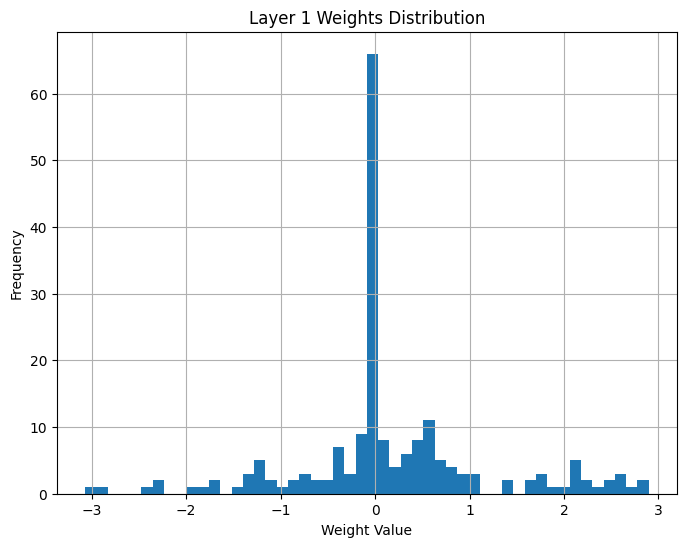

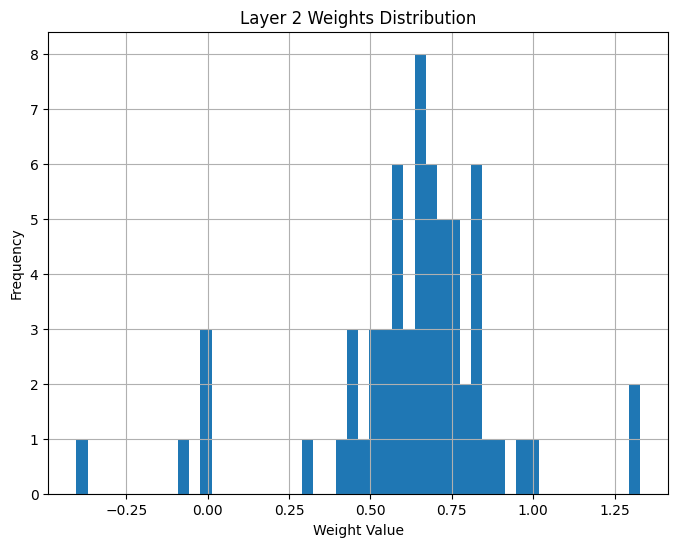

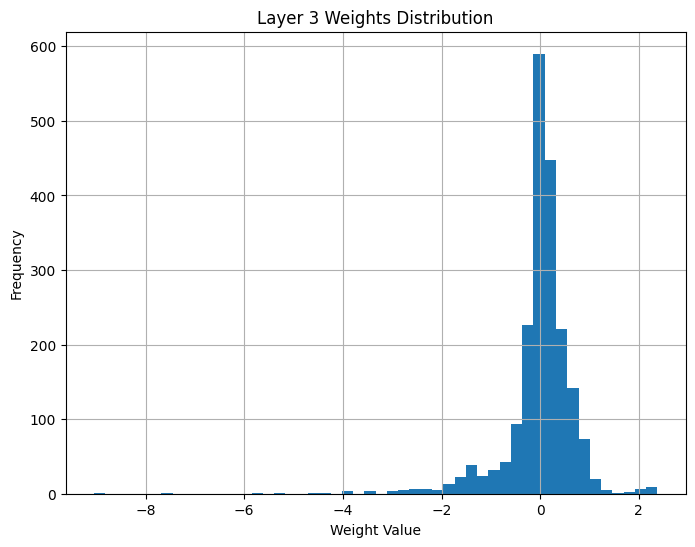

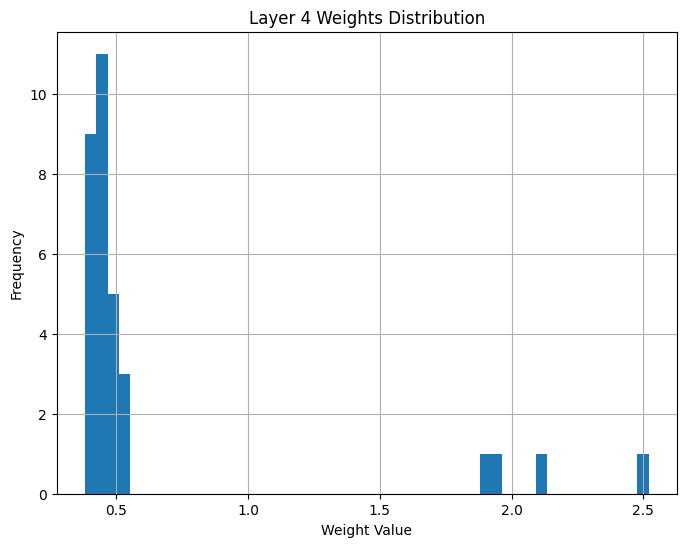

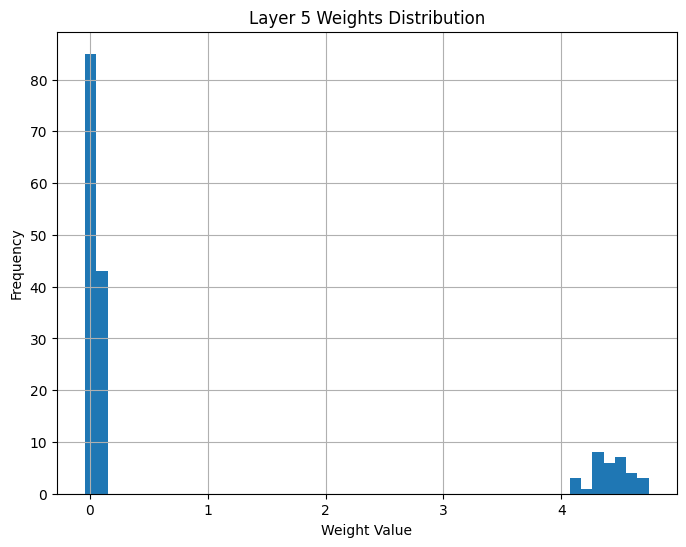

In [192]:
# Extract weights from the model's layers
def extract_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().numpy())
    return weights

# Get the weights from the model
model_weights = extract_weights(model)

# Visualize the weights of each layer
for i, layer_weights in enumerate(model_weights, 1):
    plt.figure(figsize=(8, 6))
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f"Layer {i} Weights Distribution")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [193]:
def display_menu(city_coordinates):
    print("Select a city:")
    for index, (city, coordinates) in enumerate(city_coordinates.items(), start=1):
        print(f"{index}. {city}")

In [194]:
def get_city_choice(city_coordinates):
    while True:
        display_menu(city_coordinates)
        choice = input("Enter the number corresponding to the city: ")
        try:
            choice = int(choice)
            if 1 <= choice <= len(city_coordinates):
                city = list(city_coordinates.keys())[choice - 1]
                coordinates = city_coordinates[city]
                return city, coordinates
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

In [195]:
# Get user's choice of city and coordinates
selected_city, selected_coordinates = get_city_choice(city_coordinates)
print(f"You selected: {selected_city} with coordinates: {selected_coordinates}")

Select a city:
1. Istanbul
2. Ankara
3. İzmir
4. Bursa
5. Antalya
6. Konya
7. Gaziantep
8. Şanlıurfa
9. Mersin
10. Adana
11. Diyarbakır
12. Kayseri
13. Samsun
14. Akçaabat
15. Denizli
16. Çankaya
17. Esenyurt
18. Eskişehir
19. Seyhan
20. Küçükçekmece
21. Erzurum
22. Bağcılar
23. Pendik
24. Selçuklu
25. Yıldırım
26. Kartal
27. Batman
28. Esenler
29. Kahramanmaraş
30. Kâğıthane
31. Avcılar
32. Trabzon
33. Malatya
34. Elazığ
35. Yüreğir
36. Hatay
37. Sivas
38. Gebze
39. Kocaeli
40. Kayapınar
41. Manisa
42. Konak
43. Van
44. Pamukkale
45. Sarıyer
46. Meram
47. Tarsus
48. Balıkesir
49. Beylikdüzü
50. Sultanbeyli
51. Aksaray
52. Alanya
53. Yeşilyurt
54. Adıyaman
55. Afyonkarahisar
56. İskenderun
57. Battalgazi
58. Çorum
59. Güngören
60. Çorlu
61. Sakarya
62. Arnavutköy
63. İnegöl
64. Kütahya
65. Osmaniye
66. Isparta
67. Siverek
68. Tuzla
69. Kızıltepe
70. Uşak
71. Çekme
72. Büyükçekmece
73. Beykoz
74. Düzce
75. Manavgat
76. Ordu
77. Bolu
78. Tekirdağ
79. Tokat
80. Viranşehir
81. Karaköprü
82

In [196]:
# Get the timestamp for today minus 1 hour
input_date = (datetime.now() - timedelta(hours=1))
prediction_data = [input_date.strftime('%Y-%m-%d %H:%M:%S'), selected_city]
prediction_data

['2024-01-08 17:07:38', 'İskenderun']

In [197]:
# Convert the date-time string to a timestamp
date_string = prediction_data[0]
date_time = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
timestamp = date_time.timestamp()
timestamp

1704722858.0

In [198]:
# Get the coordinates of the selected city
selected_city = prediction_data[1]
selected_coordinates = city_coordinates.get(selected_city)
selected_coordinates

(36.5817, 36.165)

In [199]:
 # Combine timestamp and coordinates into a single tensor
tensor_data = [timestamp] + list(selected_coordinates)
tensor_array = torch.tensor(tensor_data)
tensor_array = tensor_array.unsqueeze(0)
tensor_array

tensor([[1.7047e+09, 3.6582e+01, 3.6165e+01]])

In [200]:
model.eval()
# Perform predictions
with torch.no_grad():
    predictions = model(tensor_array)
    print(predictions)

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 4.7940e+06, 1.3099e+09]])


In [207]:
min_value = 0  # Minimum expected wind speed
max_value = 30  # Maximum expected wind speed
min_surface_pressure = 870  # Minimum expected surface pressure
max_surface_pressure = 1080  # Maximum expected surface pressure

In [208]:
predictions_numpy_array = predictions.numpy()
predictions_numpy_array

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.5979909e+05,
        6.2374585e+06]], dtype=float32)

In [209]:
# Column names as per your format
column_names = ['rain', 'snowfall', 'cloud_cover', 'wind_speed_10m', 'surface_pressure']

# Convert NumPy array to DataFrame
predictions_frame = pd.DataFrame(predictions_numpy_array, columns=column_names)

,rain,snowfall,cloud_cover,wind_speed_10m,surface_pressure
0,0.0,0.0,1.0,5326.63623,29698.041016


In [211]:
# Normalize the values in predictions_frame
predictions_frame['wind_speed_10m'] = (predictions_frame['wind_speed_10m'] - min_value) / (max_value - min_value)
predictions_frame['surface_pressure'] = (predictions_frame['surface_pressure'] - min_surface_pressure) / (max_surface_pressure - min_surface_pressure)
predictions_frame

,rain,snowfall,cloud_cover,wind_speed_10m,surface_pressure
0,0.0,0.0,1.0,5.918485,-3.48916
